In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
import torchvision.transforms as transforms
from torchvision.transforms.functional import to_pil_image
import cv2  # OpenCV for image processing
from transformers import ViTForImageClassification, ViTFeatureExtractor
from safetensors.torch import load_file
import matplotlib.pyplot as plt
from transformers import ViTForImageClassification
from PIL import Image
from torchvision import datasets

# Import model.

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Test with: {device}")

model = ViTForImageClassification.from_pretrained(
'google/vit-base-patch16-224-in21k',
num_labels=4,
problem_type="multi_label_classification"
)

# print(model.vit.encoder.layer[-1])

state_dict = load_file("ViT_doctor.safetensors")
model.load_state_dict(state_dict)

feature_extractor = ViTFeatureExtractor.from_pretrained('google/vit-base-patch16-224-in21k')

Test with: cpu


Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


# ReciproCAM.

In [10]:
import copy
import torch


class ViTReciproCam:
    '''
    ViTReciproCam class contains official implementation of Reciprocal CAM algorithm for ViT architecture
    published at https://arxiv.org/pdf/2310.02588.
    '''

    def __init__(self, model, device, target_layer_name=None, is_gaussian=True, block_index=-2, cls_token=True):
        '''
        Creator of ViTReciproCAM class

        Args:
            model: CNN architectur pytorch model
            device: runtime device type (ex, 'cuda', 'cpu')
            target_layer_name: layer name for understanding the layer's activation
            is_gaussian: boolean value for using gaussian filter
            block_index: encoding block index for using CAM
            cls_token: boolean value for using class token
        '''

        self.model = copy.deepcopy(model)
        self.model.eval()
        self.target_layer_name = target_layer_name
        self.device = device
        self.is_gaussian = is_gaussian
        self.cls_token = cls_token
        self.softmax = torch.nn.Softmax(dim=1)
        self.feature = None
        self.target_layers = []
        self._find_target_layer()
        if block_index == -1:
            print('Last block layer cannot be used for CAM, so using the second last block layer.')
            block_index = -2
        self.target_layers[block_index].register_forward_hook(self._cam_hook())

        filter = [[1/16.0, 1/8.0, 1/16.0],
                    [1/8.0, 1/4.0, 1/8.0],
                    [1/16.0, 1/8.0, 1/16.0]]
        self.gaussian = torch.tensor(filter).to(device)


    def _find_target_layer(self):
        '''
        Searching target layer by name from given network model.
        '''
        if self.target_layer_name:
            for name, module in self.model.named_modules():
                if self.target_layer_name in name:
                    self.target_layers.append(module)
        else:
            for name, module in self.model.named_modules():
                if isinstance(module, torch.nn.LayerNorm):
                    self.target_layer_name = name.split('.')[-1]
                    break
            for name, module in self.model.named_modules():
                if self.target_layer_name in name:
                    self.target_layers.append(module)


    def _cam_hook(self):
        '''
        Setup hook funtion for generating new masked features for calculating reciprocal activation score
        '''

        def fn(_, input, output):
            self.feature = output[0].unsqueeze(0)
            bs, tn, dim = self.feature.shape
            new_features = self._generate_masked_feature(tn, dim)
            new_features = torch.cat((self.feature, new_features), dim = 0)
            return new_features

        return fn


    def _generate_masked_feature(self, tn, dim):
        '''
        Generate spatially masked feature map [h*w, nc, h, w] from input feature map [1, nc, h, w].
        If is_gaussian is true then the spatially masked feature map's value are filtered by 3x3 Gaussian filter.
        '''

        new_outputs = torch.zeros(tn-1, tn, dim).to(self.device)
        if self.is_gaussian == False:
            for i in range(tn-1):
                if self.cls_token == True:
                    new_outputs[i, 0, :] = self.feature[0, 0, :]
                new_outputs[i, i+1, :] = self.feature[0, i+1, :]
        else:
            n_c = int((tn-1)**0.5)
            spatial_feature = self.feature[0,1:,:]
            spatial_feature = spatial_feature.reshape(1, n_c, n_c, dim)
            if self.cls_token == True:
                new_outputs[:,0,:] = self.feature[0,0,:]
            new_outputs_r = new_outputs[:,1:,:]
            new_outputs_r = new_outputs_r.reshape(tn-1,n_c,n_c,dim)
            score_map = self.gaussian.reshape(3,3,1).repeat(1,1,dim)
            for i in range(n_c):
                ky_s = max(i-1, 0)
                ky_e = min(i+1, n_c-1)
                if i == 0: sy_s = 1
                else: sy_s = 0
                if i == n_c-1: sy_e = 1
                else: sy_e = 2
                for j in range(n_c):
                    kx_s = max(j-1, 0)
                    kx_e = min(j+1, n_c-1)
                    if j == 0: sx_s = 1
                    else: sx_s = 0
                    if j == n_c-1: sx_e = 1
                    else: sx_e = 2
                    new_outputs_r[i*n_c+j, ky_s:ky_e+1, kx_s:kx_e+1, :] \
                        = spatial_feature[0, ky_s:ky_e+1, kx_s:kx_e+1, :] \
                        * score_map[sy_s:sy_e+1, sx_s:sx_e+1, :]
            new_outputs_r = new_outputs_r.reshape(tn-1,tn-1,dim)
        return new_outputs


    def _get_token_weight(self, predictions, index, num_tokens):
        '''
        Calculate class activation map from the prediction result of mosaic feature input.
        '''

        n_c = int((num_tokens-1)**0.5)
        weight = (predictions[:, index]).reshape((n_c, n_c))
        weight_min = weight.min()
        diff = weight.max() - weight_min
        weight = (weight - weight_min) / (diff)

        return weight


    def __call__(self, input_tensor, index=None):

        with torch.no_grad():
            predictions = self.model(input_tensor)
            predictions = predictions.logits
            predictions = self.softmax(predictions)

            if index == None:
                index = predictions[0].argmax().item()

            bs, t_n, dim = self.feature.shape
            cam = self._get_token_weight(predictions[1:, :], index, t_n)
            cam = cam.detach()

        return cam, index


In [11]:
import numpy as np
from matplotlib import cm
from PIL import Image

# Function to create heatmap overlay
def overlay_heatmap(img: Image.Image, mask: Image.Image, colormap: str = "jet", alpha: float = 0.7) -> Image.Image:
    """Overlay a colormapped mask on a background image

    Args:
        img: background image
        mask: mask to be overlayed in grayscale
        colormap: colormap to be applied on the mask
        alpha: transparency of the background image

    Returns:
        overlayed image
    """

    cmap = cm.get_cmap(colormap)
    # Resize mask and apply colormap
    overlay = mask.resize(img.size, resample=Image.BICUBIC)
    overlay = (255 * cmap(np.asarray(overlay) ** 2)[:, :, :3]).astype(np.uint8)
    # Overlay the image with the mask
    overlayed_img = Image.fromarray((alpha * np.asarray(img) + (1 - alpha) * overlay).astype(np.uint8))

    return overlayed_img

# Single prediction + ReciproCAM.

In [18]:
!rm -rf /content/Dataset/.ipynb_checkpoints

Predicted class: COVID
Recipro CAM Execution Time:  19.593875646591187  :  0


<ipython-input-11-089c48faff07>:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm.get_cmap(colormap)


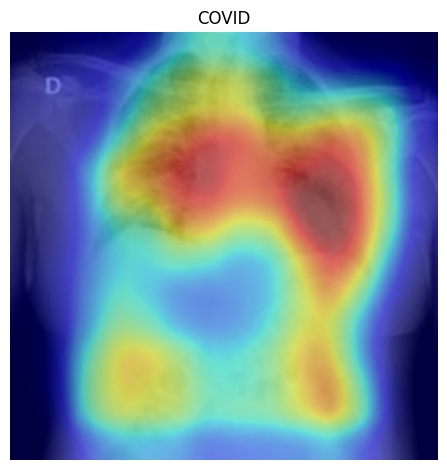

In [26]:
input_file_name = '/content/Dataset/COVID/COVID-855.png'

test_dataset = datasets.ImageFolder("/content/Dataset")
idx_to_class = {v: k for k, v in test_dataset.class_to_idx.items()}


normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    normalize,
])

img = Image.open(input_file_name).convert("RGB")
input_tensor = transform(img).to(device)
img = np.asarray(img)

begin_time = time.time()
# Instantiate ViTReciproCam
vit_reciprocam = ViTReciproCam(model, device)
# Get CAM and index
cam, class_id = vit_reciprocam(input_tensor.unsqueeze(0))
last_time = time.time()
predicted_class = idx_to_class[class_id]
print("Predicted class:", predicted_class)

print('Recipro CAM Execution Time: ', last_time - begin_time, ' : ', class_id)
result = overlay_heatmap(to_pil_image(img), to_pil_image(cam.detach(), mode='F'), alpha=0.5)

plt.imshow(result)
plt.title(f'{predicted_class}')
plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
# COVID-855, Normal-12, Covid-8

# Multiple prediction + reciproCAM.

In [ ]:
class ViTDataset(datasets.ImageFolder):
    def __getitem__(self, index):
        image, label = super().__getitem__(index)  # Load image and label
        image = feature_extractor(images=image, return_tensors="pt")["pixel_values"].squeeze(0)  # Apply feature extractor
        return image, label

In [6]:
import matplotlib.pyplot as plt
import torch
from torch.utils.data import DataLoader

# Setup the dataset and dataloader
test_dataset = ViTDataset(root="/content/Dataset")
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Initialize variables for accuracy
correct = 0
total = 0

# Model evaluation
with torch.no_grad():
    for images, labels in test_loader:
        # Get model outputs
        outputs = model(pixel_values=images)
        preds = torch.argmax(outputs.logits, dim=1)

        # Update accuracy
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Display images with predicted and true labels
        for i in range(images.size(0)):
            img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert tensor to numpy array for visualization
            img = (img - img.min()) / (img.max() - img.min())  # Normalize image for proper display

            true_label = labels[i].item()
            predicted_label = preds[i].item()

            print(f"True: {test_dataset.classes[true_label]} | Pred: {test_dataset.classes[predicted_label]}")
            if true_label != predicted_label:
                plt.imshow(img)
                plt.show()

# Print overall test accuracy
print(f"Test Accuracy: {100 * correct / total:.2f}%")